# FORMULA 1 LAP ANALYSIS 

# Import Libraries

In [1]:
pip install fastf1

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c conda-forge fastf1

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): conda.anaconda.org:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
- DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/osx-64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://conda.anaconda.org:443 "GET /conda-forge/osx-64/current_repodata.json HTTP/1.1" 200 None
\ DEBUG:urllib3.connectionpool:https://conda.anaconda.org:443 "GET /conda-forge/noarch/

In [3]:
pip install windrose

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import sys
import fastf1

try:
    fastf1.Cache.enable_cache(sys.path[0]+"/fastf1_cache")
except:
    os.makedirs(sys.path[0]+"/fastf1_cache")
    fastf1.Cache.enable_cache(sys.path[0]+"/fastf1_cache") 

#this code is trying to enable caching for the fastf1 library. 
#If the cache directory doesn't exist, it creates the directory and then attempts to enable caching again. 
#The purpose of this is to ensure that the necessary cache directory is available for storing
#and retrieving cached data.


from fastf1 import plotting
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import datetime
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
import numpy as np
from windrose import WindroseAxes
pd.set_option('display.max_columns', None)

# Load Race(Input Race Name and Year)

In [5]:
# input session and year
year = 2023
location = 'Abu Dhabi'
session = 'R'

# get session
"""
    session identifier:
    'FP1', 'FP2', 'FP3', 'Q', 'S', 'SQ', 'SS', 'R
    'Practice 1', 'Practice 2', 'Practice 3', 'Qualifying', 'Sprint', 'Sprint Qualifying', 'Sprint Shootout', 'Race'
"""

race = fastf1.get_session(year, location, session)
race.load(weather=True)

core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.1.6]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '11', '4', '81', '14', '22', '44', '18', '3', '31', '10', '23', '27', '2', '24', '55', '77', '20']


# Load Dataframe and Preprocessing

In [6]:
# load race laps
race_name = race.event.OfficialEventName
df = race.laps

# load dataframe of df (by Final Position in ascending order)
df = df[df['Deleted']==False] 
df = df.sort_values(by=['LapNumber','Position'], ascending=[False, True]).reset_index(drop=True)

# fill in empty laptime records and convert to seconds
df.LapTime = df.LapTime.fillna(df['Sector1Time']+df['Sector2Time']+df['Sector3Time'])
df.LapTime = df.LapTime.dt.total_seconds()
df.Sector1Time = df.Sector1Time.dt.total_seconds()
df.Sector2Time = df.Sector2Time.dt.total_seconds()
df.Sector3Time = df.Sector3Time.dt.total_seconds()

# weather
df_weather = race.weather_data.copy()
df_weather['Time'] = df_weather['Time'].dt.total_seconds()/60
df_weather = df_weather.rename(columns={'Time':'SessionTime(Minutes)'})

# Rain Indicator
rain = df_weather.Rainfall.eq(True).any() 

In [7]:
df

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 02:29:27.481000,VER,1,88.545,58.0,3.0,NaT,NaT,17.590,38.071,32.884,0 days 02:28:16.526000,0 days 02:28:54.597000,0 days 02:29:27.481000,NaN,300.0,203.0,303.0,False,HARD,15.0,True,Red Bull Racing,0 days 02:27:58.936000,2023-11-26 14:29:00.061,1,1.0,False,,False,True
1,0 days 02:29:43.934000,PER,11,87.948,58.0,3.0,NaT,NaT,17.641,37.826,32.481,0 days 02:28:33.608000,0 days 02:29:11.434000,0 days 02:29:43.915000,294.0,307.0,210.0,332.0,False,HARD,16.0,True,Red Bull Racing,0 days 02:28:15.986000,2023-11-26 14:29:17.111,1,2.0,False,,False,True
2,0 days 02:29:45.474000,LEC,16,91.284,58.0,3.0,NaT,NaT,19.151,38.712,33.421,0 days 02:28:33.335000,0 days 02:29:12.047000,0 days 02:29:45.468000,258.0,317.0,208.0,320.0,False,HARD,23.0,True,Ferrari,0 days 02:28:14.190000,2023-11-26 14:29:15.315,1,3.0,False,,False,True
3,0 days 02:29:47.809000,RUS,63,88.820,58.0,3.0,NaT,NaT,17.781,38.287,32.752,0 days 02:28:36.708000,0 days 02:29:14.995000,0 days 02:29:47.747000,292.0,306.0,212.0,307.0,False,HARD,24.0,True,Mercedes,0 days 02:28:18.989000,2023-11-26 14:29:20.114,1,4.0,False,,False,True
4,0 days 02:29:51.765000,NOR,4,88.588,58.0,3.0,NaT,NaT,17.610,38.255,32.723,0 days 02:28:40.731000,0 days 02:29:18.986000,0 days 02:29:51.709000,295.0,302.0,212.0,305.0,False,HARD,25.0,True,McLaren,0 days 02:28:23.177000,2023-11-26 14:29:24.302,1,5.0,False,,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,0 days 01:04:05.157000,BOT,77,100.300,1.0,1.0,NaT,NaT,NaN,39.862,35.683,NaT,0 days 01:03:29.534000,0 days 01:04:05.268000,280.0,287.0,212.0,293.0,False,HARD,1.0,True,Alfa Romeo,0 days 01:02:24.519000,2023-11-26 13:03:25.644,1,16.0,False,,False,False
1120,0 days 01:04:05.405000,ALB,23,100.625,1.0,1.0,NaT,NaT,NaN,40.189,35.489,NaT,0 days 01:03:30.097000,0 days 01:04:05.518000,287.0,287.0,211.0,289.0,False,MEDIUM,2.0,False,Williams,0 days 01:02:24.519000,2023-11-26 13:03:25.644,1,17.0,False,,False,False
1121,0 days 01:04:05.761000,ZHO,24,100.960,1.0,1.0,NaT,NaT,NaN,39.804,36.005,NaT,0 days 01:03:29.878000,0 days 01:04:05.815000,289.0,294.0,212.0,303.0,False,MEDIUM,1.0,True,Alfa Romeo,0 days 01:02:24.519000,2023-11-26 13:03:25.644,1,18.0,False,,False,False
1122,0 days 01:04:06.454000,MAG,20,101.597,1.0,1.0,NaT,NaT,NaN,40.288,36.471,NaT,0 days 01:03:30.081000,0 days 01:04:06.503000,282.0,277.0,212.0,309.0,False,MEDIUM,1.0,True,Haas F1 Team,0 days 01:02:24.519000,2023-11-26 13:03:25.644,1,19.0,False,,False,False


# Load Results and Gap Calculation

In [8]:
# Results
if session in ('Q','SQ','Qualifying','Sprint Qualifying'):
    df_results = race.results
    df_results['BestQTime'] = round(df_results.apply(lambda row: min(row.Q1, row.Q2, row.Q3), axis=1).dt.total_seconds(),3)
else:
    df_results = df.loc[df.groupby(['Driver'])['LapTime'].idxmin()].sort_values('LapTime', ascending=True).rename(columns={'Driver':'Abbreviation'}).reset_index()
    df_results['BestQTime'] = df_results['LapTime']

df_results['GapToBest'] = df_results.apply(lambda row: round(row.BestQTime - df_results.BestQTime.min(),3), axis=1)
df_results = df_results.sort_values('GapToBest')

# Gap to Best Driver

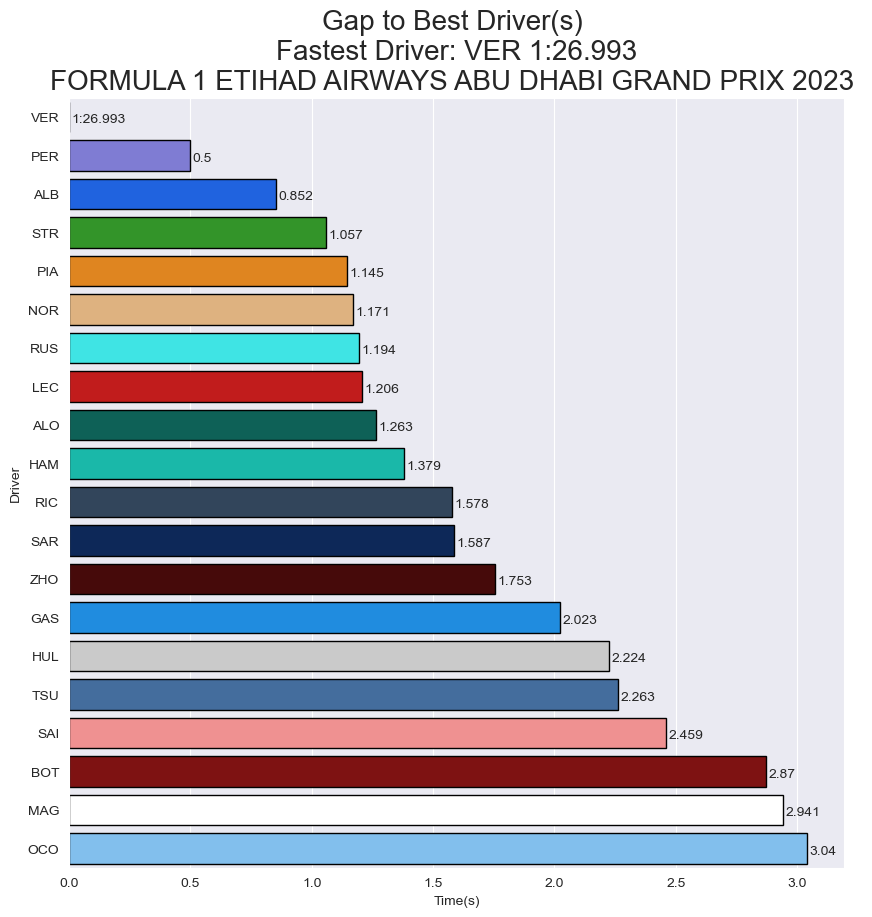

In [9]:
# for driver color palette
driver_color = {}
for index,row in df_results.iterrows():
    driver = row['Abbreviation'] #Abbreviation: Short names of drivers
    driver_color[driver] = fastf1.plotting.driver_color(driver)

plt.figure(figsize=(10,10))
sns.barplot(data=df_results, x='GapToBest', y='Abbreviation', palette=driver_color,  edgecolor='black')
plt.ylabel('Driver')
plt.xlabel('Time(s)')
plt.title(f'Gap to Best Driver(s) \nFastest Driver: {df_results.Abbreviation[0]} {int(df_results.BestQTime[0]/60)}:{round(df_results.BestQTime[0]-60,3)}\n{race_name}', fontsize=20)
# to add data labels
plt.text(df_results.GapToBest[0]+0.01, 0.15, f'{int(df_results.BestQTime[0]/60)}:{round(df_results.BestQTime[0]-60,3)}', ha = 'left') # for 1st driver
for i in range(1,len(df_results)):
    plt.text(df_results.GapToBest[i]+0.01, i+0.15, df_results.GapToBest[i], ha = 'left')  
plt.show()

# Telemetry Data for Fastest Drivers

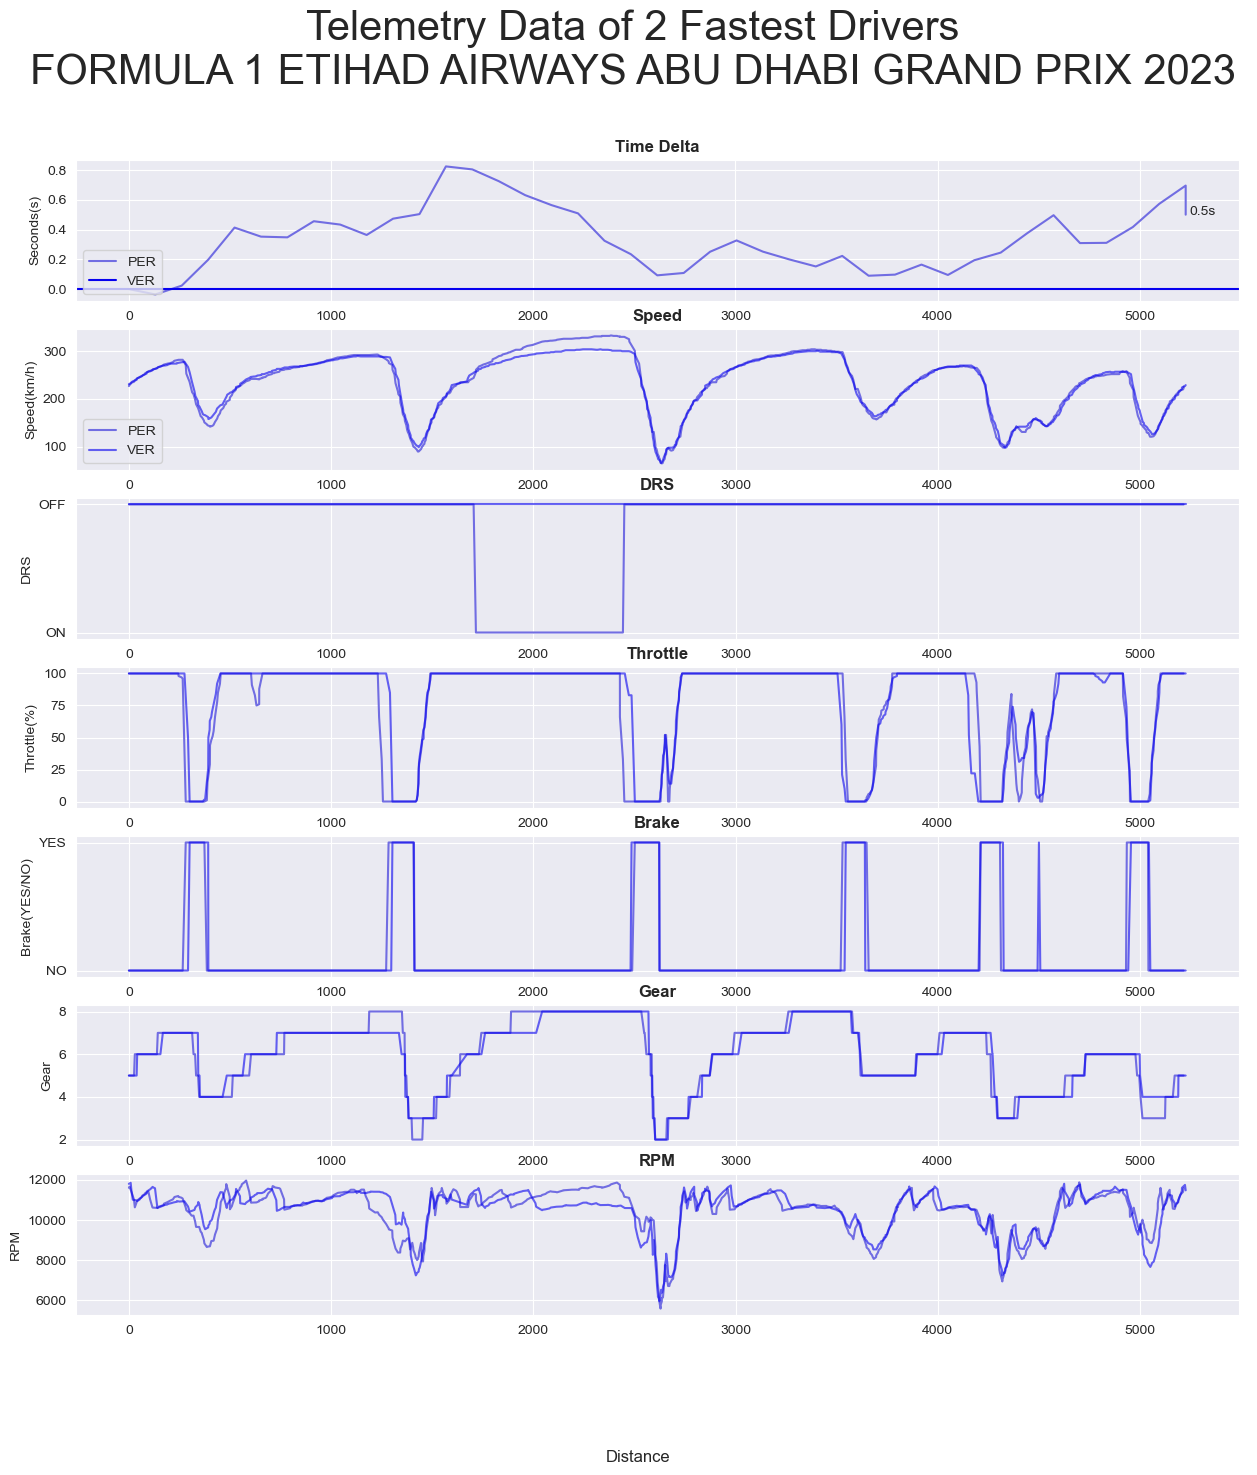

In [10]:
# get telemetry data
driver_1_lap = df.loc[df.pick_driver(df_results.Abbreviation[0])['LapTime'].idxmin()]
driver_1_tel = driver_1_lap.get_telemetry()
driver_1_tel['Driver'] = df_results.Abbreviation[0]
driver_2_lap = df.loc[df.pick_driver(df_results.Abbreviation[1])['LapTime'].idxmin()]
driver_2_tel = driver_2_lap.get_telemetry()
driver_2_tel['Driver'] = df_results.Abbreviation[1]
driver_3_lap = df.loc[df.pick_driver(df_results.Abbreviation[2])['LapTime'].idxmin()]
driver_3_tel = driver_3_lap.get_telemetry()
driver_3_tel['Driver'] = df_results.Abbreviation[2]

# data transform

# join all 3 drivers data
telemetry = pd.concat([driver_1_tel, driver_2_tel, driver_3_tel])

# creating minisectors
total_minisectors = 40
telemetry['Minisector'] = pd.cut(telemetry['Distance'], total_minisectors, labels = False) + 1

# calculate time delta for top 2 drivers
time_used = telemetry.groupby(['Minisector', 'Driver'])['Time'].mean().reset_index().rename(columns={'Time':'BestTime'})
time_used['BestDriverTime'] = time_used.apply(lambda x: time_used.loc[(time_used.Driver == df_results.Abbreviation[0]) & (time_used.Minisector == x.Minisector), 'BestTime'].min(), axis=1)
time_used['TimeDelta'] = time_used['BestTime'].dt.total_seconds() - time_used['BestDriverTime'].dt.total_seconds()

# PLOTTING!!!
fig, ax = plt.subplots(7, figsize=(15, 15))
fig.suptitle('Telemetry Data of 2 Fastest Drivers \n'+race_name, fontsize=30)
fig.supxlabel('Distance')

# Time Delta
# Create a list 'second_driver_time_delta' containing time deltas for the second driver
second_driver_time_delta = [0] + time_used.loc[time_used.Driver == df_results.Abbreviation[1], 'TimeDelta'].to_list()+[df_results.GapToBest[1]]
# Create a list 'distance_array' representing distances for each minisector
distance_array = [0] + [i*telemetry.Distance.max()/total_minisectors for i in range(1,total_minisectors+1)] + [telemetry.Distance.max()]
# Plot the data on the first subplot (ax[0])
ax[0].plot(distance_array, second_driver_time_delta, color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
# Add a horizontal line at y=0 with color corresponding to the first driver
ax[0].axhline(y=0, color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0])
# Add a text annotation at the end of the plot to display the gap to the best time for the second driver
ax[0].text(max(distance_array)+20, df_results.GapToBest[1], f"{df_results.GapToBest[1]}s")
ax[0].legend(loc = 'lower left')
ax[0].set_title('Time Delta', fontweight="bold")
ax[0].set(ylabel= 'Seconds(s)')

# Speed
ax[1].plot(driver_2_tel['Distance'], driver_2_tel['Speed'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[1].plot(driver_1_tel['Distance'], driver_1_tel['Speed'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0], alpha = 0.6) # This is often done to visually distinguish overlapping lines.
ax[1].legend(loc = 'lower left')
ax[1].set_title('Speed', fontweight="bold")
ax[1].set(ylabel= 'Speed(km/h)')

# DRS
# transform DRS
driver_1_tel['DRS_Activated'] = driver_1_tel['DRS'].map(lambda x: 'ON' if x >= 10 else 'OFF')
driver_2_tel['DRS_Activated'] = driver_2_tel['DRS'].map(lambda x: 'ON' if x >= 10 else 'OFF')
ax[2].plot(driver_2_tel['Distance'], driver_2_tel['DRS_Activated'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[2].plot(driver_1_tel['Distance'], driver_1_tel['DRS_Activated'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0], alpha = 0.6)
ax[2].invert_yaxis()
ax[2].set_title('DRS', fontweight="bold")
ax[2].set(ylabel= 'DRS')

# Throttle
ax[3].plot(driver_2_tel['Distance'], driver_2_tel['Throttle'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[3].plot(driver_1_tel['Distance'], driver_1_tel['Throttle'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0], alpha = 0.6)
ax[3].set_title('Throttle', fontweight="bold")
ax[3].set(ylabel= 'Throttle(%)')

# Brake
ax[4].plot(driver_2_tel['Distance'], driver_2_tel['Brake'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[4].plot(driver_1_tel['Distance'], driver_1_tel['Brake'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0], alpha = 0.6)
ax[4].set_yticks(ticks = [1,0], labels = ["YES", "NO"])
ax[4].set_title('Brake', fontweight="bold")
ax[4].set(ylabel= 'Brake(YES/NO)')

# Gear
ax[5].plot(driver_2_tel['Distance'], driver_2_tel['nGear'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[5].plot(driver_1_tel['Distance'], driver_1_tel['nGear'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0], alpha = 0.6)
ax[5].set_title('Gear', fontweight="bold")
ax[5].set(ylabel= 'Gear')

# RPM
ax[6].plot(driver_2_tel['Distance'], driver_2_tel['RPM'], color = driver_color[df_results.Abbreviation[1]], label = df_results.Abbreviation[1])
ax[6].plot(driver_1_tel['Distance'], driver_1_tel['RPM'], color = driver_color[df_results.Abbreviation[0]], label = df_results.Abbreviation[0], alpha = 0.6)
ax[6].set_title('RPM', fontweight="bold")
ax[6].set(ylabel= 'RPM')

plt.show()

In [11]:
telemetry

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Distance,RelativeDistance,Status,X,Y,Z,Driver,Minisector
2,2023-11-26 14:09:58.762,0 days 02:08:57.637000,,NaN,0 days 00:00:00,11804,231,5,100,False,0,interpolation,0.007964,0.000002,OnTrack,637,2087,-238,VER,1
3,2023-11-26 14:09:58.900,0 days 02:08:57.775000,,NaN,0 days 00:00:00.138000,11855,233,5,100,False,0,car,8.950000,0.001706,OnTrack,768,2104,-239,VER,1
4,2023-11-26 14:09:58.962,0 days 02:08:57.837000,,NaN,0 days 00:00:00.200000,11435,235,5,100,False,0,pos,13.009768,0.002480,OnTrack,813,2110,-240,VER,1
5,2023-11-26 14:09:59.060,0 days 02:08:57.935000,,NaN,0 days 00:00:00.298000,11015,237,5,100,False,0,car,19.483333,0.003714,OnTrack,866,2116,-239,VER,1
6,2023-11-26 14:09:59.341,0 days 02:08:58.216000,,NaN,0 days 00:00:00.579000,10980,240,5,100,False,0,pos,38.425522,0.007326,OnTrack,972,2128,-239,VER,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,2023-11-26 14:12:27.741,0 days 02:11:26.616000,27,294.190000,0 days 00:01:27.400000,10340,212,5,100,False,0,car,5198.823611,0.993762,OnTrack,287,2050,-237,ALB,40
660,2023-11-26 14:12:27.882,0 days 02:11:26.757000,27,296.145556,0 days 00:01:27.541000,10468,218,5,100,False,0,pos,5207.482674,0.995417,OnTrack,373,2056,-238,ALB,40
661,2023-11-26 14:12:28.061,0 days 02:11:26.936000,27,298.101111,0 days 00:01:27.720000,10596,224,6,100,False,0,car,5218.734722,0.997568,OnTrack,470,2066,-238,ALB,40
662,2023-11-26 14:12:28.102,0 days 02:11:26.977000,27,298.101111,0 days 00:01:27.761000,10683,226,6,100,False,0,pos,5221.330042,0.998064,OnTrack,494,2070,-239,ALB,40


# Track Dominance

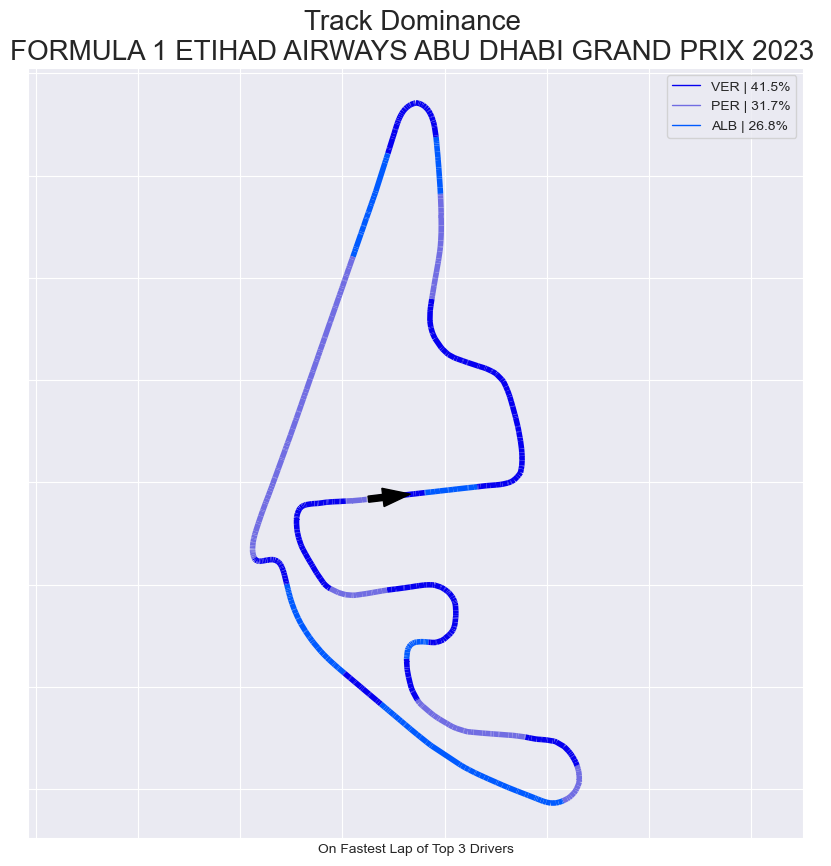

In [12]:
# Track Dominance
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()
best_sectors = average_speed.groupby(['Minisector'])['Speed'].max().reset_index()
best_sectors = best_sectors.merge(average_speed[['Speed','Driver']], on=['Speed']).rename(columns={'Driver':'FastestSectorDriver', 'Speed':'FastestSectorSpeed'})
track_dominance = best_sectors.FastestSectorDriver.value_counts(normalize=True)
best_sectors = best_sectors.merge(telemetry, on=['Minisector'])

# Get Lap Data
single_lap = telemetry.loc[telemetry['Driver'] == df_results.Abbreviation[0]]
lap_x = np.array(single_lap['X'].values)
lap_y = np.array(single_lap['Y'].values)

# points and segments for drawing lap
points = np.array([lap_x, lap_y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Get Fastest Driver of each minisector
best_sectors['FastestSectorDriver'] = best_sectors['FastestSectorDriver'].map({df_results.Abbreviation[0]:1,df_results.Abbreviation[1]:2,df_results.Abbreviation[2]:3})
map_sectors = best_sectors.loc[best_sectors['Driver'] == df_results.Abbreviation[0]]

# getting colormap
colors = [driver_color[df_results.Abbreviation[i]] for i in range(3)]
cmap = ListedColormap(colors)

# coordinates
lc_comp = LineCollection(segments, norm = plt.Normalize(1, cmap.N), cmap = cmap)
lc_comp.set_array(map_sectors['FastestSectorDriver'])
lc_comp.set_linewidth(4)

# plot
plt.rcParams['figure.figsize'] = [10,10]
plt.title('Track Dominance \n'+race_name, fontsize=20)
plt.xlabel('On Fastest Lap of Top 3 Drivers')
plt.gca().add_collection(lc_comp)
plt.arrow(lap_x[0], lap_y[0], lap_x[5]-lap_x[0], lap_y[5]-lap_y[0], width=150, color='black', zorder=100)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
legend_lines = [Line2D([0], [0], color = driver_color[df_results.Abbreviation[i]], lw = 1) for i in range(3)]
plt.legend(legend_lines, 
           [f"{df_results.Abbreviation[0]} | {round(track_dominance[df_results.Abbreviation[0]]*100,1)}%", 
            f"{df_results.Abbreviation[1]} | {round(track_dominance[df_results.Abbreviation[1]]*100,1)}%", 
            f"{df_results.Abbreviation[2]} | {round(track_dominance[df_results.Abbreviation[2]]*100,1)}%"])
plt.show()


# Fastest Drivers in Each Sector

Text(0.5, 1.0, 'Sector 3')

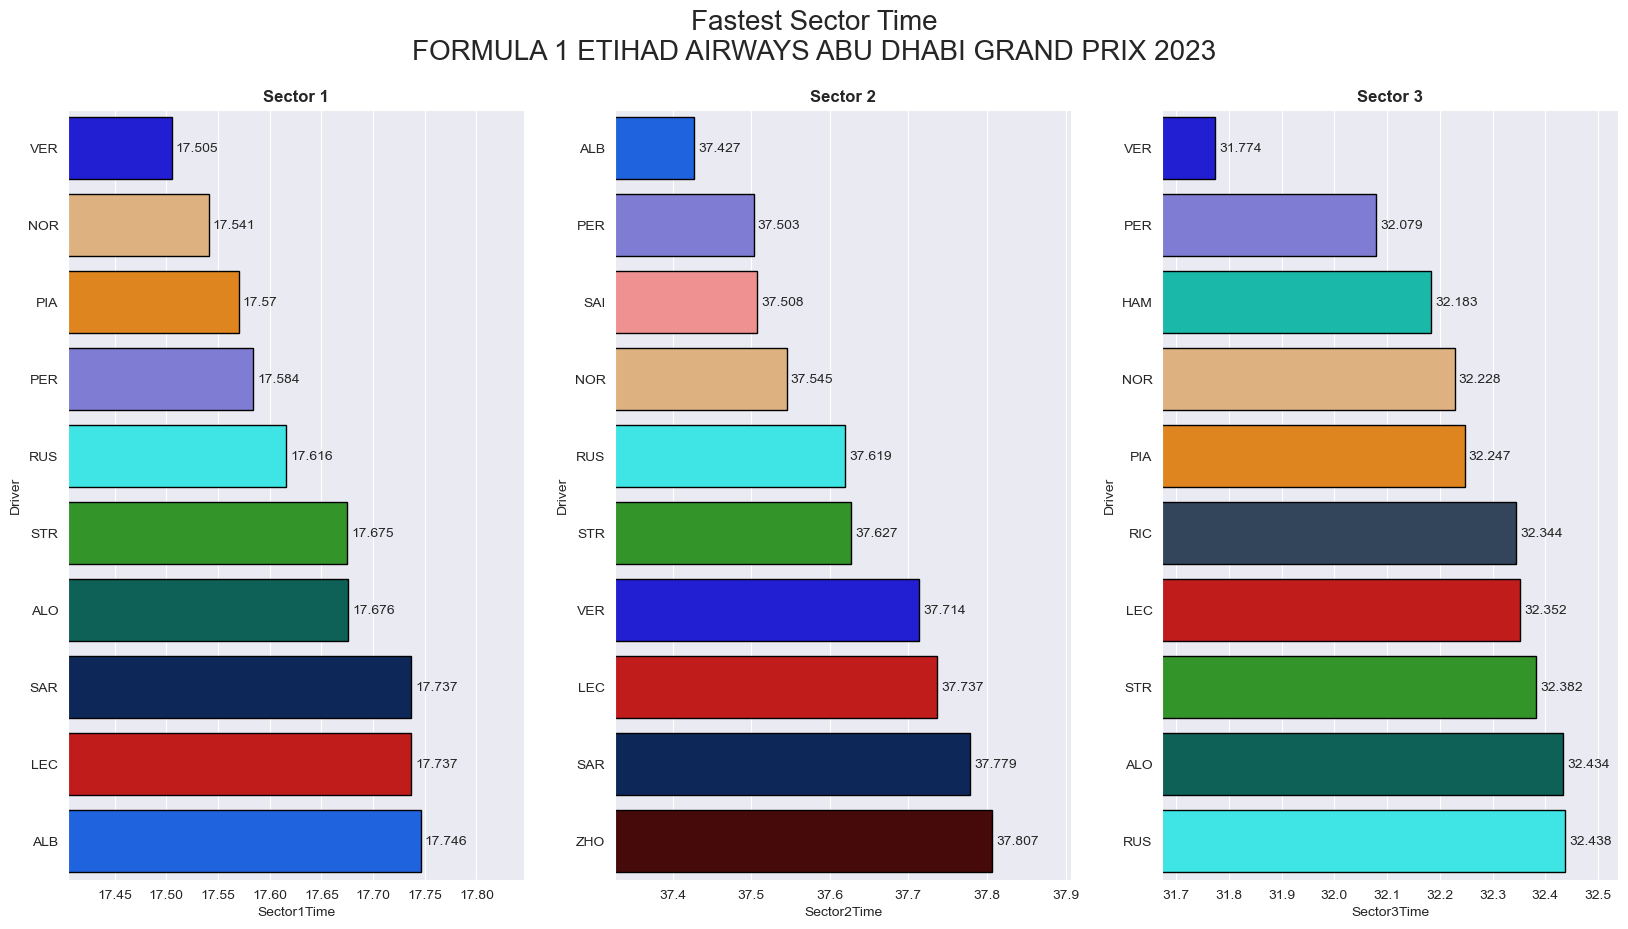

In [13]:
# Get the top 10 fastest SectorTime
top_10_sector1 = df.groupby(['Driver'])['Sector1Time'].min().sort_values().head(10).reset_index()
top_10_sector2 = df.groupby(['Driver'])['Sector2Time'].min().sort_values().head(10).reset_index()
top_10_sector3 = df.groupby(['Driver'])['Sector3Time'].min().sort_values().head(10).reset_index()

fig, ax = plt.subplots(1,3, figsize=(20, 10))
fig.suptitle('Fastest Sector Time \n'+race_name, fontsize=20)

# Sector 1
sns.barplot(x=top_10_sector1['Sector1Time'], y=top_10_sector1['Driver'], palette=driver_color, ax=ax[0], edgecolor='black')
ax[0].bar_label(ax[0].containers[0], padding=3)
ax[0].set_xlim(top_10_sector1.Sector1Time[0]-0.1,top_10_sector1.Sector1Time[9]+0.1)
ax[0].set_title('Sector 1', fontweight="bold")

# Sector 2
sns.barplot(x=top_10_sector2['Sector2Time'], y=top_10_sector2['Driver'], palette=driver_color, ax=ax[1], edgecolor='black')
ax[1].bar_label(ax[1].containers[0], padding=3)
ax[1].set_xlim(top_10_sector2.Sector2Time[0]-0.1,top_10_sector2.Sector2Time[9]+0.1)
ax[1].set_title('Sector 2', fontweight="bold")

# Sector 3
sns.barplot(x=top_10_sector3['Sector3Time'], y=top_10_sector3['Driver'], palette=driver_color, ax=ax[2], edgecolor='black')
ax[2].bar_label(ax[2].containers[0], padding=3)
ax[2].set_xlim(top_10_sector3.Sector3Time[0]-0.1,top_10_sector3.Sector3Time[9]+0.1)
ax[2].set_title('Sector 3', fontweight="bold")

# Top Speed and Min Speed of Each Team

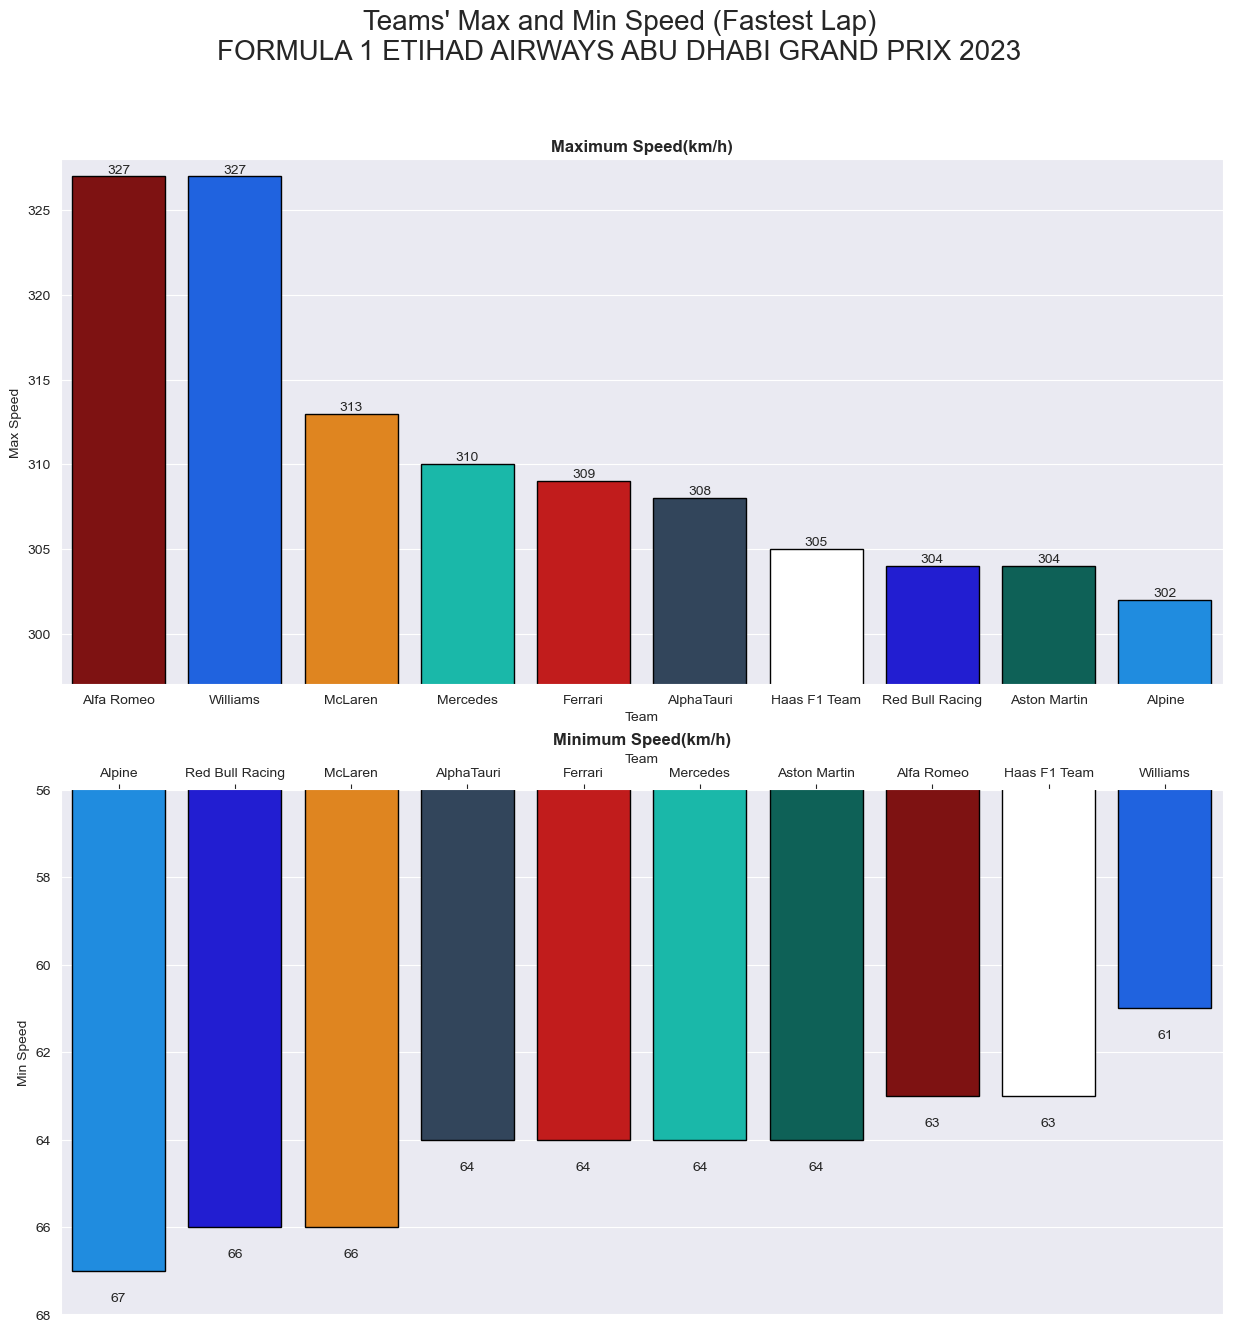

In [14]:
# top speed and min speed of each team
team_max_speed = {}
team_min_speed = {}

for team in set(df.Team):
    team_max_speed[team] = df.pick_team(team).pick_fastest().get_telemetry().Speed.max()
    team_min_speed[team] = df.pick_team(team).pick_fastest().get_telemetry().Speed.min()

team_max_speed = pd.DataFrame(team_max_speed.items(), columns=['Team', 'Max Speed']).sort_values('Max Speed', ascending=False).reset_index()
team_min_speed = pd.DataFrame(team_min_speed.items(), columns=['Team', 'Min Speed']).sort_values('Min Speed', ascending=False).reset_index()

# for colour palette
team_color = {}
for team in team_max_speed.Team:
    team_color[team] = fastf1.plotting.team_color(team)

fig, ax = plt.subplots(2, figsize=(15, 15))
fig.suptitle('Teams\' Max and Min Speed (Fastest Lap) \n'+race_name, fontsize=20)

# Max Speed
sns.barplot(data=team_max_speed, x='Team', y='Max Speed' , palette=team_color, ax=ax[0], edgecolor='black')
ax[0].set_ylim(team_max_speed['Max Speed'].min()-5, team_max_speed['Max Speed'].max()+1)
ax[0].set_title('Maximum Speed(km/h)', fontweight="bold")
# to add data labels
for i in range(len(team_max_speed)):
    ax[0].text(i, team_max_speed['Max Speed'][i]+0.2, team_max_speed['Max Speed'][i], ha = 'center')  

# Min Speed
sns.barplot(data=team_min_speed, x='Team', y='Min Speed' , palette=team_color, ax=ax[1], edgecolor='black')
ax[1].set_ylim(team_min_speed['Min Speed'].min()-5, team_min_speed['Min Speed'].max()+1)
ax[1].set_title('Minimum Speed(km/h)', fontweight="bold")
ax[1].invert_yaxis()
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top') 
# to add data labels
for i in range(len(team_min_speed)):
    ax[1].text(i, team_min_speed['Min Speed'][i]+0.7, team_min_speed['Min Speed'][i], ha = 'center')  

# General Weather Data & Track Evolution

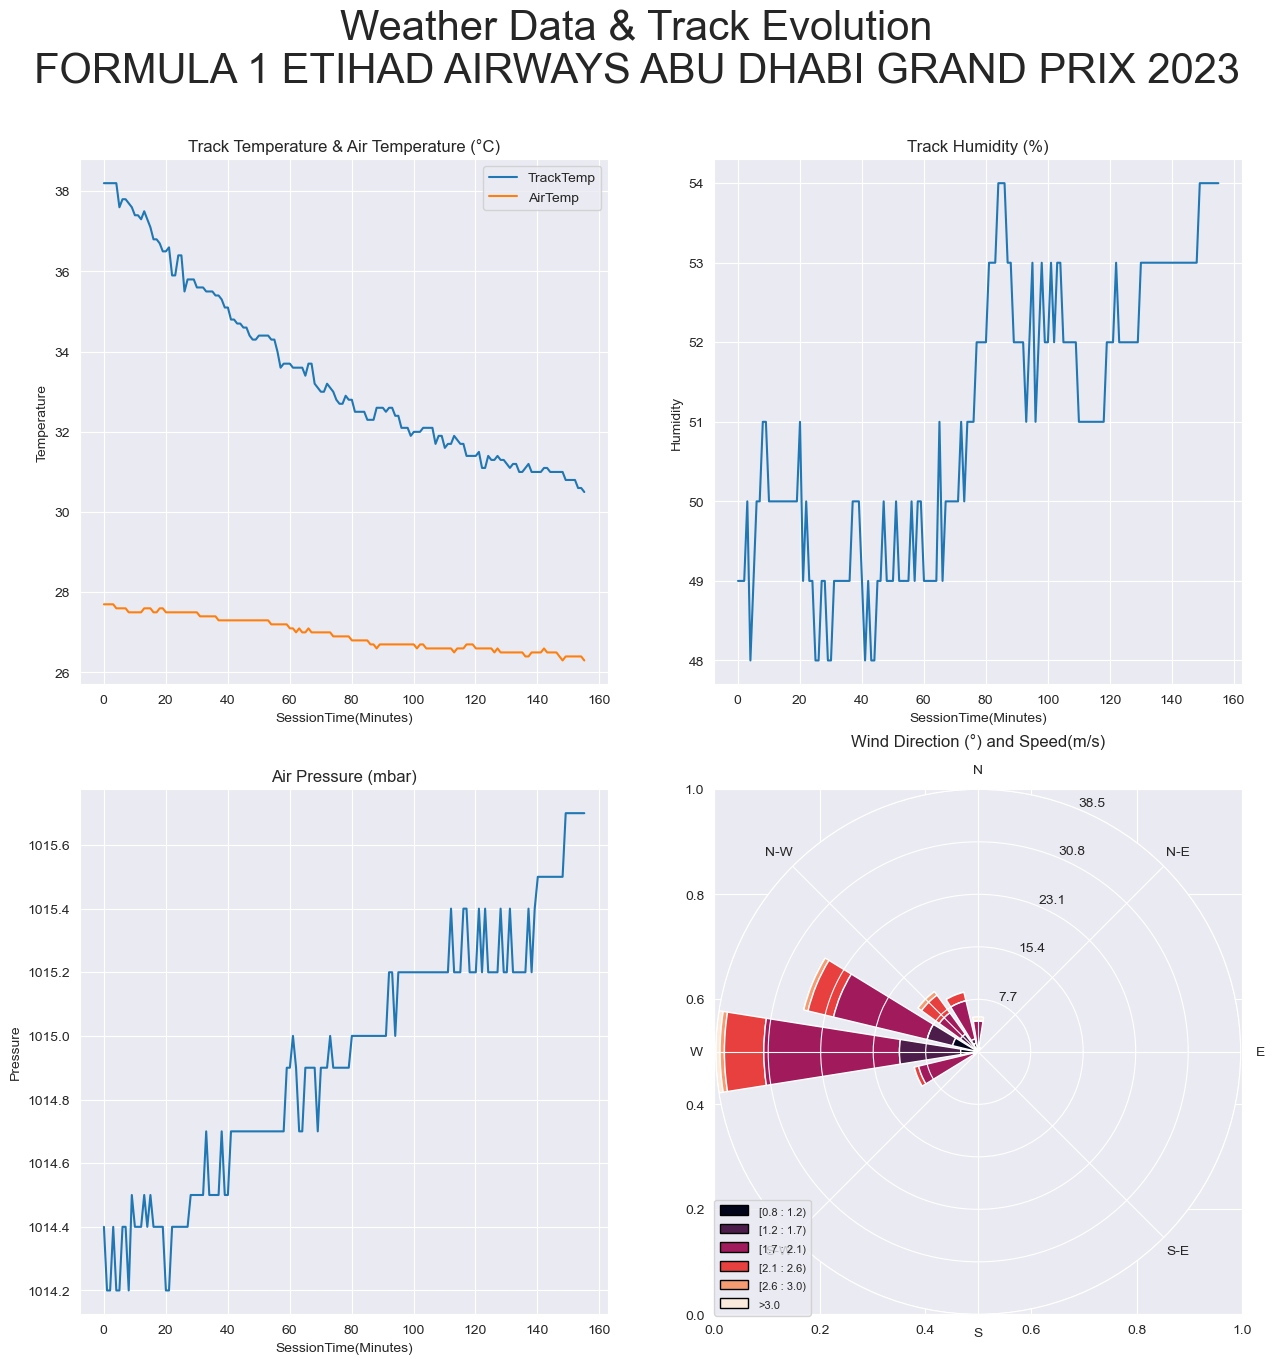

In [15]:
fig, ax = plt.subplots(2,2, figsize=(15, 15))
fig.suptitle('Weather Data & Track Evolution \n'+race_name, fontsize=30)

# Track and Air Temperature
sns.lineplot(data = df_weather, x='SessionTime(Minutes)', y='TrackTemp', label = 'TrackTemp', ax = ax[0,0])
sns.lineplot(data = df_weather, x='SessionTime(Minutes)', y='AirTemp', label = 'AirTemp', ax = ax[0,0])
if rain:
    ax[0,0].fill_between(df_weather[df_weather.Rainfall == True]['SessionTime(Minutes)'], df_weather.TrackTemp.max()+0.5, df_weather.AirTemp.min()-0.5, facecolor="blue", color='blue', alpha=0.1, zorder=0, label = 'Rain')   
ax[0,0].legend(loc='upper right')
ax[0,0].set_ylabel('Temperature')
ax[0,0].title.set_text('Track Temperature & Air Temperature (°C)')

# Humidity
sns.lineplot(df_weather, x='SessionTime(Minutes)', y='Humidity', ax=ax[0,1])
if rain:
    ax[0,1].fill_between(df_weather[df_weather.Rainfall == True]['SessionTime(Minutes)'], df_weather.Humidity.max()+0.5, df_weather.Humidity.min()-0.5, facecolor="blue", color='blue', alpha=0.1, zorder=0, label = 'Rain')   
    ax[0,1].legend(loc='upper right')
ax[0,1].title.set_text('Track Humidity (%)')

# Pressure
sns.lineplot(data = df_weather, x='SessionTime(Minutes)', y='Pressure', ax = ax[1,0])
ax[1,0].title.set_text('Air Pressure (mbar)')

# Wind Direction & Speed
rect = ax[1,1].get_position()
wax = WindroseAxes(fig, rect)
fig.add_axes(wax)
wax.bar(df_weather.WindDirection, df_weather.WindSpeed, normed=True, opening=0.8, edgecolor='white')
wax.set_legend()
ax[1,1].title.set_text('Wind Direction (°) and Speed(m/s)\n\n')